<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/map_estimation/raw/main/img/DATAIA-h.png" width="90%"></a>
</div>

# Non-invasive estimation of the MAP using PPG

<i> Thomas Moreau (Inria) </i>


<div style="text-align: center;">
<img src=img/GA_monitor_1.png width=600px alt="Monitor in a operating room"></img>
</div>


## Introduction

The continuous monitoring of blood pressure is a major challenge in the general anesthesia field. Indeed, the monitoring of blood pressure is essential to ensure that the patient is stable during the operation. However, the current methods to measure blood pressure are either non-invasive, but non-continuous, or invasive, which can lead to complications, and expensive, making them inadapted in many situations.


<div style="text-align: center;">
<img src=img/cuff.avif width=350px alt="Cuff for blood pressure measurment"></img>
</div>

A potential solution to this problem is to use non-invasive monitoring signals which are routinely collected, like the electrocardiogram (ECG)  photoplethysmogram (PPG) signal, to estimate the mean arterial pressure (MAP) using AI. The PPG signal is a non-invasive signal that can be easily acquired using a pulse oximeter. The MAP is a measure of the average blood pressure in an individual's arteries during one cardiac cycle.

<div style="text-align: center;">
<img src=img/ecg.avif height=250px alt="ECG sensors"></img>
<img src=img/ppg.png height=250px alt="PPG sensor"></img>
</div>

The goal of this challenge is to estimate the MAP from the non-invasive signals. The dataset consists of window of 10 seconds of PPG and ECG signals, with the related patient information (age, gender, weight, height, etc.) and the MAP measured with an invasive method.

A particular aspect of this challenge is the fact that we would like to have a
method that can generalize well to new patients in other hospitals. This is a
major issue in the medical field, where the data distribution can change and
it is very costly to collect new data.

For this reason, the challenge is a domain adaptation challenge. For training,
you have access to a dataset composed of data from 2 different domains:

- The "source" domain `'v'`, which corresponds to data collected in a first hospital.
  For this data, you have access to all the data and the labels (i.e. the MAP).
- The "target" domain `'m'`, composed of data collected in a second hospital.
  For this data, you have access to the data, but not the labels. In order to make it possible to test that everything is working properly, we give you the labels for 100 segments of the target domain in the test set.

The goal is therefore to generalize from the source domain to the target domain.

#### Extra resources

For this challenge, you can take a look at the following resources:

- [`skada`](https://scikit-adaptation.github.io/): a library for domain adaptation (DA) with a scikit-learn and PyTorch/skorch compatible API. This library implement many existing DA methods and can be used to implement your own methods.

# Exploratory data analysis

This notebook provides a simple exploratory data analysis of the dataset.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import problem

### Load the data

The data is composed of 10 seconds windows of PPG and ECG signals, and the goal is to predict the MAP from these signals.

For this challenge, the data is large (>20Gb) so it cannot be loaded directly
when not enough RAM is available.
In this case, the data can be loaded in chunks (using `start/stop` arguments of `get_train_data`) or without all the high frequency waveforms (`load_waveform=False`).

In this notebook, we first load all the data without the waveforms to
illustrate the data distribution.

In [9]:
import problem
X_df, y = problem.get_train_data(load_waveform=False)

In [10]:
print(X_df.shape, y.shape)


(300750, 10) (300750,)


  
Let's first look at the data available.

In [11]:
print(f"There are {X_df.shape[0]} segment in this dataset.")
X_df.head()

There are 300750 segment in this dataset.


,n_seg,subject,age,gender,domain,height,weight,bmi,id,chunk
0,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
1,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
2,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
3,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN
4,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,NaN


The data has two types of features:
- Some patient information like the subject identifier, the age, the gender and the number of segment for this patient.
- The PPG and ECG signals in the segment.

We first start by looking at the statistics of the data:

There are 1203 unique subjects in the train set.


<Axes: title={'center': 'Number of segments per domain'}, xlabel='domain'>

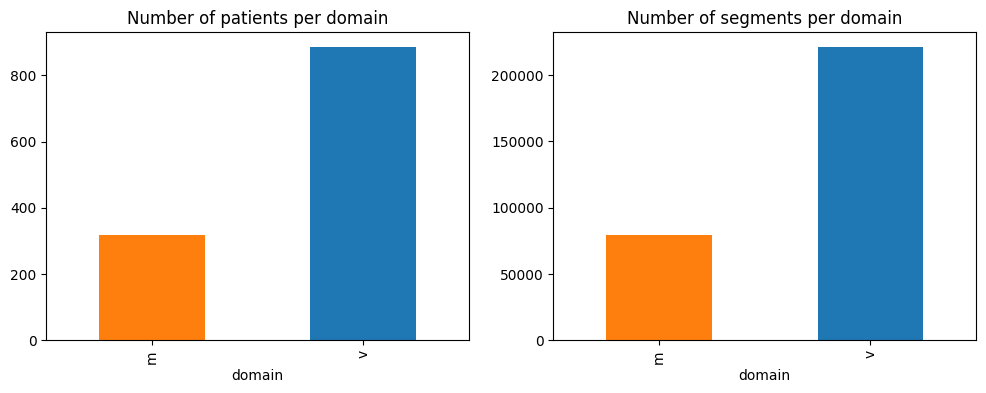

In [12]:
print(
    f"There are {X_df['subject'].nunique()} unique subjects in the train set."
)
# Display the number of subject/segments for each domain
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
X_df.groupby("domain")['subject'].apply(lambda x: x.nunique()).plot.bar(
    ax=axes[0], color=["C1", "C0"], title="Number of patients per domain"
)
X_df.groupby("domain").size().plot.bar(
    ax=axes[1], color=["C1", "C0"], title="Number of segments per domain"
)


We now look at the demographic information of the patients:

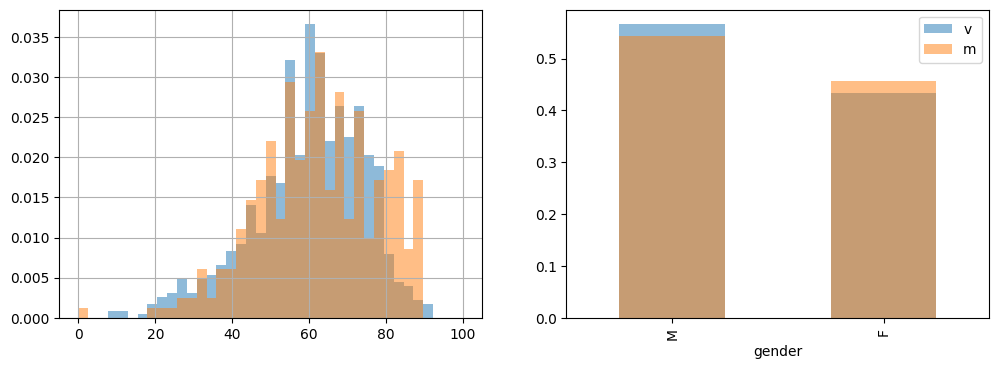

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bins = np.linspace(0, 100, 40)
for i, domain in enumerate(["v", "m"]):
    X_ = X_df.query("domain == @domain")
    X_["age"].hist(
        ax=axes[0], bins=bins, density=True, alpha=0.5,
        label=domain, color=f"C{i}"
    )
    (X_["gender"].value_counts() / len(X_)).plot(
        kind="bar", ax=axes[1], label=domain, alpha=0.5, color=f"C{i}"
    )
plt.legend()


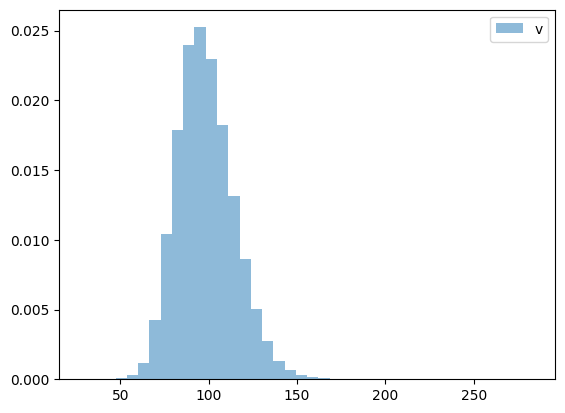

In [19]:
# Now let's check the distribution of the target
plt.hist(y[y != -1], bins=40, density=True, alpha=0.5, label="v")
plt.legend()

We see here that the distribution is skewed. Indeed, the international guidelines for anesthesiologist recommend a MAP between 70 and 105 mmHg, and to avoid having hypotension during the procedure.
As this data is observational, we see that we have very few data points with a MAP below 70 mmHg, which might be a problem for the model to learn the distribution of the MAP.


Now, we turn to the high-frequency signals contained in the data.
To avoid loading the entire dataset, we will load only the first 1000 rows of
the dataset.

In [40]:
import os
os.environ["RAMP_TEST_MODE"] = "1"

X_v, y = problem.get_train_data(start=0, stop=100)
X_m, y_m = problem.get_train_data(start=-1001, stop=-1)
X_df = pd.concat([X_v, X_m], axis=0)
y = np.concatenate([y, y_m])

X_df

,n_seg,subject,age,gender,domain,height,weight,bmi,id,ecg,ppg,chunk
0,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",NaN
1,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",NaN
2,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",NaN
3,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",NaN
4,688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2785793562708102, 0.28412874583795783, 0.25...","[0.19241192411924118, 0.1603432700993677, 0.13...",val
2096,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2987085906793936, 0.3161145423919146, 0.212...","[0.11162361623616242, 0.11531365313653143, 0.1...",val
2097,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.20290697674418606, 0.1430232558139535, 0.10...","[0.04311482622085346, 0.04311482622085346, 0.0...",val
2098,470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.19429778247096094, 0.18373812038014786, 0.1...","[0.20263870094722602, 0.18775372124492556, 0.1...",val


The waveforms are stored as specific columns containing numpy arrays.  
They contain:
- **ECG:** the electrocardiogram signal, which is a measure of the electrical activity of the heart.
- **PPG:** the photoplethysmogram signal, which is a measure of the blood volume changes in the arteries.

We can plot them to see what they look like, and display the MAP value for each segment.  
Note that in this context, we do not have access to the MAP value for the target domain `m`.

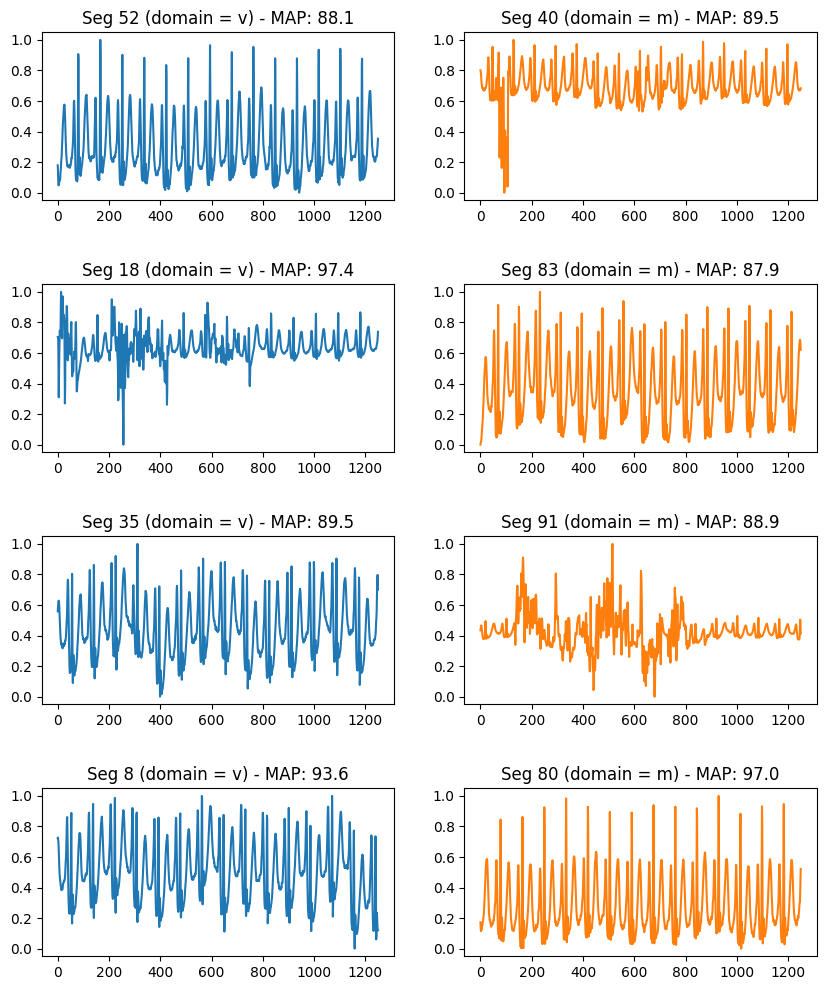

In [41]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.random.choice(min(100, len(X_m), len(X_v)), size=8, replace=False)
for i, ax in enumerate(axes.ravel()):
    d = "v" if i % 2 == 0 else "m"
    X_, y_ = (X_v, y) if i % 2 == 0 else (X_m, y_m)

    ax.plot(X_.iloc[idx[i]]['ecg'], c=f"C{i % 2}")
    ax.set_title(f"Seg {idx[i]} (domain = {d}) - MAP: {y_[idx[i]]:.1f}")

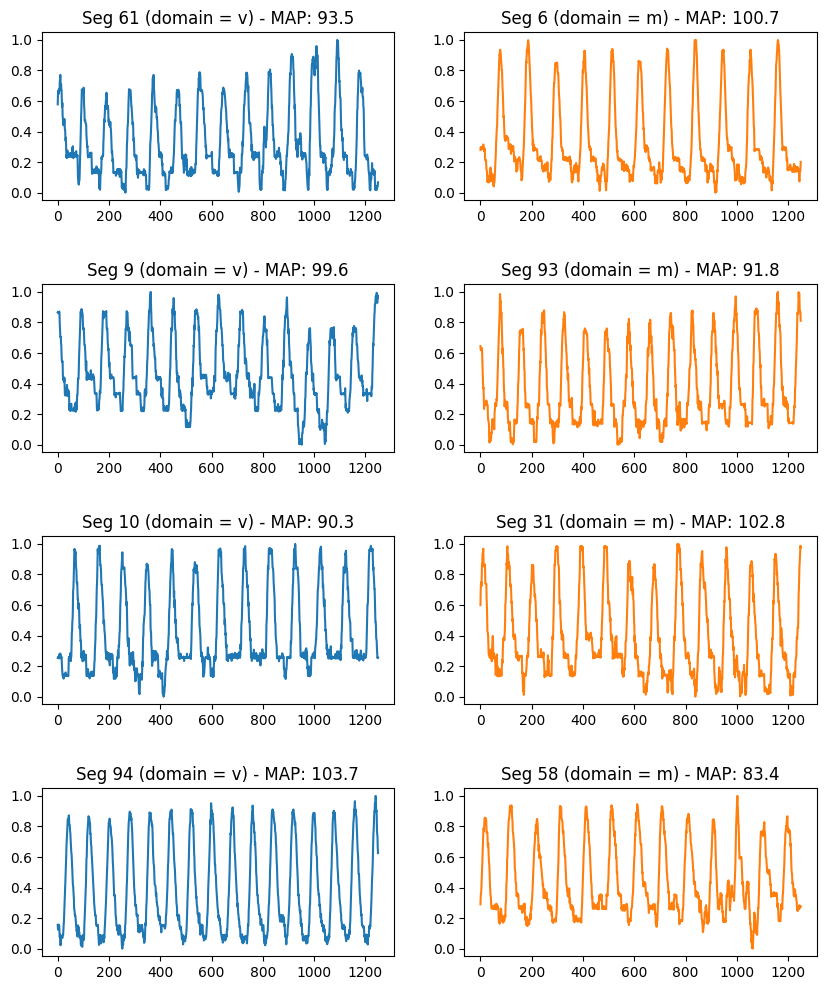

In [42]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.random.choice(min(100, len(X_m), len(X_v)), size=8, replace=False)
for i, ax in enumerate(axes.ravel()):
    d = "v" if i % 2 == 0 else "m"
    X_, y_ = (X_v, y) if i % 2 == 0 else (X_m, y_m)

    ax.plot(X_.iloc[idx[i]]['ppg'], c=f"C{i % 2}")
    ax.set_title(f"Seg {idx[i]} (domain = {d}) - MAP: {y_[idx[i]]:.1f}")

# Data preprocessing 

In [2]:
import os
os.environ["RAMP_TEST_MODE"] = "1"

X_v, y = problem.get_train_data(start=0, stop=100)# source domain 
X_m, y_m = problem.get_train_data(start=-101, stop=-1) # target domain
X_df = pd.concat([X_v, X_m], axis=0)
y = np.concatenate([y, y_m])

X_df['label'] = y
X_df.set_index('n_seg', inplace=True)
X_df

,subject,age,gender,domain,height,weight,bmi,id,ecg,ppg,chunk,label
n_seg,,,,,,,,,,,,
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",NaN,84.718337
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",NaN,91.438156
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",NaN,95.325744
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",NaN,107.161807
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",NaN,91.184162
...,...,...,...,...,...,...,...,...,...,...,...,...
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2785793562708102, 0.28412874583795783, 0.25...","[0.19241192411924118, 0.1603432700993677, 0.13...",val,82.354120
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2987085906793936, 0.3161145423919146, 0.212...","[0.11162361623616242, 0.11531365313653143, 0.1...",val,82.470310
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.20290697674418606, 0.1430232558139535, 0.10...","[0.04311482622085346, 0.04311482622085346, 0.0...",val,83.278458


In [3]:
X_df.isnull().sum()

subject       0
age           0
gender        0
domain        0
height     2200
weight     2200
bmi        2200
id            0
ecg           0
ppg           0
chunk      4000
label         0
dtype: int64

In [4]:
# drop chunk 
X_df.drop('chunk', axis=1, inplace=True)
X_df

,subject,age,gender,domain,height,weight,bmi,id,ecg,ppg,label
n_seg,,,,,,,,,,,
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",84.718337
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",91.438156
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",95.325744
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",107.161807
688,p000750,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",91.184162
...,...,...,...,...,...,...,...,...,...,...,...
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2785793562708102, 0.28412874583795783, 0.25...","[0.19241192411924118, 0.1603432700993677, 0.13...",82.354120
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2987085906793936, 0.3161145423919146, 0.212...","[0.11162361623616242, 0.11531365313653143, 0.1...",82.470310
470,p090269,76.0,M,m,NaN,NaN,NaN,186.0,"[0.20290697674418606, 0.1430232558139535, 0.10...","[0.04311482622085346, 0.04311482622085346, 0.0...",83.278458


In [5]:
# drop subject
X_df.drop('subject', axis=1, inplace=True)
X_df


,age,gender,domain,height,weight,bmi,id,ecg,ppg,label
n_seg,,,,,,,,,,
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",84.718337
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",91.438156
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",95.325744
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",107.161807
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",91.184162
...,...,...,...,...,...,...,...,...,...,...
470,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2785793562708102, 0.28412874583795783, 0.25...","[0.19241192411924118, 0.1603432700993677, 0.13...",82.354120
470,76.0,M,m,NaN,NaN,NaN,186.0,"[0.2987085906793936, 0.3161145423919146, 0.212...","[0.11162361623616242, 0.11531365313653143, 0.1...",82.470310
470,76.0,M,m,NaN,NaN,NaN,186.0,"[0.20290697674418606, 0.1430232558139535, 0.10...","[0.04311482622085346, 0.04311482622085346, 0.0...",83.278458


In [6]:
# drop nulls form height, weight et bmi 
X_df.dropna(subset=['height', 'weight', 'bmi'], inplace=True)
X_df

,age,gender,domain,height,weight,bmi,id,ecg,ppg,label
n_seg,,,,,,,,,,
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",84.718337
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",91.438156
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",95.325744
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",107.161807
688,78.0,M,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",91.184162
...,...,...,...,...,...,...,...,...,...,...
264,48.0,M,v,169.0,76.1,26.6,1.0,"[0.07375290270576584, 0.09428073018130861, 0.1...","[0.5297296018185839, 0.5996453403303931, 0.631...",93.869806
264,48.0,M,v,169.0,76.1,26.6,1.0,"[0.318527091238068, 0.3284677391334296, 0.3247...","[0.20367687891992675, 0.20659011084905127, 0.2...",86.718519
264,48.0,M,v,169.0,76.1,26.6,1.0,"[0.2739637733740973, 0.2468126223122397, 0.202...","[0.1415211004415432, 0.15393001486739444, 0.15...",84.418033


In [7]:
X_df['gender'].value_counts()

gender
M    1000
F    1000
Name: count, dtype: int64

In [8]:
X_df['gender_code'] = X_df['gender'].map({'M': 0, 'F': 1})
X_df.drop('gender', axis=1, inplace=True)
X_df

,age,domain,height,weight,bmi,id,ecg,ppg,label,gender_code
n_seg,,,,,,,,,,
688,78.0,v,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",84.718337,0
688,78.0,v,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",91.438156,0
688,78.0,v,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",95.325744,0
688,78.0,v,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",107.161807,0
688,78.0,v,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",91.184162,0
...,...,...,...,...,...,...,...,...,...,...
264,48.0,v,169.0,76.1,26.6,1.0,"[0.07375290270576584, 0.09428073018130861, 0.1...","[0.5297296018185839, 0.5996453403303931, 0.631...",93.869806,0
264,48.0,v,169.0,76.1,26.6,1.0,"[0.318527091238068, 0.3284677391334296, 0.3247...","[0.20367687891992675, 0.20659011084905127, 0.2...",86.718519,0
264,48.0,v,169.0,76.1,26.6,1.0,"[0.2739637733740973, 0.2468126223122397, 0.202...","[0.1415211004415432, 0.15393001486739444, 0.15...",84.418033,0


In [9]:
X_df['domain_code'] = X_df['domain'].map({'v': 0, 'm': 1})
X_df.drop('domain', axis=1, inplace=True)
X_df

,age,height,weight,bmi,id,ecg,ppg,label,gender_code,domain_code
n_seg,,,,,,,,,,
688,78.0,162.0,50.6,19.3,1.0,"[0.3688673837817671, 0.3620627421921535, 0.365...","[0.40960445864963035, 0.36931866813001185, 0.3...",84.718337,0,0
688,78.0,162.0,50.6,19.3,1.0,"[0.25735809742643956, 0.23910011930527947, 0.2...","[0.36706728559046503, 0.4034043141571599, 0.35...",91.438156,0,0
688,78.0,162.0,50.6,19.3,1.0,"[0.13428866369506492, 0.14334834365416743, 0.1...","[0.7494333513716098, 0.8147798178151058, 0.799...",95.325744,0,0
688,78.0,162.0,50.6,19.3,1.0,"[0.17744878960204316, 0.18312116528072353, 0.2...","[0.2668839934294831, 0.26939094339014175, 0.25...",107.161807,0,0
688,78.0,162.0,50.6,19.3,1.0,"[0.6703874816047055, 0.5075806829705767, 0.444...","[0.27162392568169147, 0.2647447495713346, 0.24...",91.184162,0,0
...,...,...,...,...,...,...,...,...,...,...
264,48.0,169.0,76.1,26.6,1.0,"[0.07375290270576584, 0.09428073018130861, 0.1...","[0.5297296018185839, 0.5996453403303931, 0.631...",93.869806,0,0
264,48.0,169.0,76.1,26.6,1.0,"[0.318527091238068, 0.3284677391334296, 0.3247...","[0.20367687891992675, 0.20659011084905127, 0.2...",86.718519,0,0
264,48.0,169.0,76.1,26.6,1.0,"[0.2739637733740973, 0.2468126223122397, 0.202...","[0.1415211004415432, 0.15393001486739444, 0.15...",84.418033,0,0


In [10]:
# replace ecg and ppg by mean
X_df['ecg_mean'] = X_df['ecg'].apply(lambda x : x.mean())
X_df['ppg_mean'] = X_df['ppg'].apply(lambda x : x.mean())
X_df.drop('ecg',axis=1 ,inplace=True)
X_df.drop('ppg',axis=1 ,inplace=True)
X_df

,age,height,weight,bmi,id,label,gender_code,domain_code,ecg_mean,ppg_mean
n_seg,,,,,,,,,,
688,78.0,162.0,50.6,19.3,1.0,84.718337,0,0,0.350685,0.392646
688,78.0,162.0,50.6,19.3,1.0,91.438156,0,0,0.362436,0.378184
688,78.0,162.0,50.6,19.3,1.0,95.325744,0,0,0.315845,0.421383
688,78.0,162.0,50.6,19.3,1.0,107.161807,0,0,0.333390,0.374980
688,78.0,162.0,50.6,19.3,1.0,91.184162,0,0,0.611131,0.344353
...,...,...,...,...,...,...,...,...,...,...
264,48.0,169.0,76.1,26.6,1.0,93.869806,0,0,0.239547,0.308786
264,48.0,169.0,76.1,26.6,1.0,86.718519,0,0,0.270301,0.342149
264,48.0,169.0,76.1,26.6,1.0,84.418033,0,0,0.243997,0.340299


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming X_df is your dataframe
X = X_df.drop(['label'], axis=1)  # Features
y = X_df['label']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-Squared: {r2}')

# Get the coefficients of the model
print('Coefficients:')
for i, column in enumerate(X.columns):
    print(f'{column}: {model.coef_[i]}')

# Get the intercept of the model
print(f'Intercept: {model.intercept_}')


Mean Squared Error: 116.77597208933575
Mean Absolute Error: 8.53571397517458
R-Squared: 0.3866380242822891
Coefficients:
age: 0.00643277252507792
height: 2.0820528048769424
weight: -0.5843934378169039
bmi: -0.7893966365391727
id: 0.008726598493335477
gender_code: 0.051232352315983526
domain_code: 0.0
ecg_mean: 2.021246510287855
ppg_mean: -11.742455637057907
Intercept: -193.0947457481472


In [12]:
# apply a random forest to the model 

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-Squared: {r2}')

Mean Squared Error: 21.54721999007377
Mean Absolute Error: 3.414235352256672
R-Squared: 0.8868239314315008


In [15]:
# fine tune the random forest 

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)


Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: 4.448694149982045


# Challenge evaluation

For this challenge, the metric used to evaluate the performance of the model is the mean absolute error (MAE) between the predicted MAP and the true MAP, defined as:

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{pred}^i - y_{true}^i|
$$

Here, we take the MAE over the test set, which is composed of signals coming
from domain `m`.

### A first model without the waveforms

We can start by building a simple model without the waveforms to see how well we can predict the MAP from the demographic information and the low-frequency signals.

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer


from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.metrics import mean_absolute_error

# ramp test


X_df, y = problem.get_train_data(load_waveform=True)
X_df_test, y_test = problem.get_test_data(load_waveform=True)


class IgnoreAdapter(RandomForestRegressor):
    def fit(self, X, y):
        X = X[~y.isna()]
        X['ppg_mean'] = X['ppg'].mean(axis=1)
        X['ecg_mean'] = X['ecg'].mean(axis=1)
        y = y[~y.isna()]
        return super().fit(X, y)

    def predict(self, X):
        return super().predict(X.drop(columns=["domain"]))


clf = make_pipeline(
    make_column_transformer(
        ("passthrough", ["age"]),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ["gender"]),
    ),
    # SimpleImputer(strategy="mean"),
    RandomForestRegressor(n_estimators=50)
    # Ridge(alpha=1)
)
clf.fit(X_df, y)
print(f"Score on train: {mean_absolute_error(clf.predict(X_df), y)}")
print(f"Score on test: {mean_absolute_error(clf.predict(X_df_test), y_test)}")

Score on train: 4.262310359848302
Score on test: 6.489986691468342


In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.metrics import mean_absolute_error

X_df, y = problem.get_train_data(load_waveform=True)
X_df_test, y_test = problem.get_test_data(load_waveform=True)

X_df['label'] = y
X_df_test['label'] = y_test


# Drop 'chunk' and 'subject' columns
X_df = X_df.drop(['chunk', 'subject'], axis=1)
X_df_test = X_df_test.drop(['chunk', 'subject'], axis=1)

# Drop rows with null values in 'height', 'weight', and 'bmi' columns
X_df = X_df.dropna(subset=['height', 'weight', 'bmi'])
X_df_test = X_df_test.dropna(subset=['height', 'weight', 'bmi'])

# Create 'gender_code' and 'domain_code' columns
X_df['gender_code'] = X_df['gender'].map({'M': 0, 'F': 1})
X_df_test['gender_code'] = X_df_test['gender'].map({'M': 0, 'F': 1})
X_df['domain_code'] = X_df['domain'].map({'v': 0, 'm': 1})
X_df_test['domain_code'] = X_df_test['domain'].map({'v': 0, 'm': 1})

# Drop 'gender' and 'domain' columns
X_df = X_df.drop(['gender', 'domain'], axis=1)
X_df_test = X_df_test.drop(['gender', 'domain'], axis=1)

# Create 'ecg_mean' and 'ppg_mean' columns
X_df['ecg_mean'] = X_df['ecg'].apply(lambda x: x.mean())
X_df_test['ecg_mean'] = X_df_test['ecg'].apply(lambda x: x.mean())
X_df['ppg_mean'] = X_df['ppg'].apply(lambda x: x.mean())
X_df_test['ppg_mean'] = X_df_test['ppg'].apply(lambda x: x.mean())

# Drop 'ecg' and 'ppg' columns
X_df = X_df.drop(['ecg', 'ppg'], axis=1)
X_df_test = X_df_test.drop(['ecg', 'ppg'], axis=1)

#drop target 
y = X_df['label'] 
X_df = X_df.drop('label', axis=1)
y_test = X_df_test['label']
X_df_test = X_df_test.drop('label', axis=1)


# Create a pipeline
clf = make_pipeline(
    make_column_transformer(
        ("passthrough", ["age", "height", "weight", "bmi", "gender_code", "domain_code", "ecg_mean", "ppg_mean"]),
    ),
    RandomForestRegressor(n_estimators=50)
)
# Train the pipeline
clf.fit(X_df, y)

# Evaluate the pipeline
y_pred = clf.predict(X_df)
print(f"Score on train: {mean_absolute_error(y, y_pred)}")

y_pred_test = clf.predict(X_df_test)
print(f"Score on test: {mean_absolute_error(y_test, y_pred_test)}")


Score on train: 2.746919761313077
Score on test: 2.746919761313077


In [84]:

def get_estimator():
    """
    This estimator assumes that the input DataFrame (X) contains the following columns:
      - "age", "height", "weight", "bmi": numeric attributes.
      - "gender": categorical variable assumed to have values "M" or "F".  
          We map these to 0 and 1 respectively.
      - "domain": categorical variable assumed to have values "v" or "m".  
          We map these to 0 and 1 respectively.
      - "ecg": a column where each cell is an array-like object from which we compute the mean.
      - "ppg": a column where each cell is an array-like object from which we compute the mean.
      
    Any extra columns (for example, "chunk" or "subject") are simply ignored.
    """

    # The following function transformers compute the mean of an array-like column.
    ecg_mean_transformer = FunctionTransformer(
        lambda X: X.apply(lambda arr: np.mean(arr)).to_frame("ecg_mean"),
        validate=False
    )
    ppg_mean_transformer = FunctionTransformer(
        lambda X: X.apply(lambda arr: np.mean(arr)).to_frame("ppg_mean"),
        validate=False
    )

    # Build a column transformer that:
    #   - passes through the numeric features,
    #   - encodes the 'gender' and 'domain' features with a specified category order
    #     so that "M" (male) is encoded as 0 and "F" (female) as 1, and similarly for "domain".
    #   - applies our FunctionTransformers to the "ecg" and "ppg" columns.
    preprocessor = make_column_transformer(
        # Pass through the numeric columns as is.
        ("passthrough", ["age", "height", "weight", "bmi"]),
        # For gender, specify categories so that 'M' maps to 0 and 'F' to 1.
        (OrdinalEncoder(categories=[["M", "F"]], handle_unknown='use_encoded_value', unknown_value=-1),
         ["gender"]),
        # For domain, we also specify the order, where 'v' maps to 0 and 'm' to 1.
        (OrdinalEncoder(categories=[["v", "m"]], handle_unknown='use_encoded_value', unknown_value=-1),
         ["domain"]),
        # Compute the mean of the signals in the "ecg" column.
        ("ecg_mean", ecg_mean_transformer, ["ecg"]),
        # Compute the mean of the signals in the "ppg" column.
        ("ppg_mean", ppg_mean_transformer, ["ppg"]),
    )

    # Create the complete pipeline.
    # This pipeline first transforms the raw DataFrame into the features we desire,
    # then fits a RandomForestRegressor using 50 trees.
    pipeline = make_pipeline(
        preprocessor,
        IgnoreAdapter(n_estimators=50)
    )

    return pipeline

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [ ]:
# %load submissions/starting_kit/estimator.py

from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

set_config(transform_output="pandas")


class IgnoreDomain(RandomForestRegressor):
    def fit(self, X, y):
        # Ignore the samples with missing target
        X = X[y != -1]
        y = y[y != -1]

        return super().fit(X, y)


def get_estimator():
    return make_pipeline(
        make_column_transformer(
            ("passthrough", ["age"]),
            ("passthrough", ["height", "weight", "bmi"]),
            (OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=-1
            ), ["gender"]),
        ),
        IgnoreDomain(n_estimators=50)
    )


In [66]:
# %load submissions/starting_kit/estimator.py
import pywt
from sklearn import set_config
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor


set_config(transform_output="pandas")

class DataFrameCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # X = X.drop('subject', axis=1)
        # X = X.dropna(subset=['height', 'weight', 'bmi'])
        X['gender_code'] = X['gender'].map({'M': 0, 'F': 1})
        # X['domain_code'] = X['domain'].map({'v': 0, 'm': 1})
        X = X.drop(['gender', 'domain'], axis=1)
        X = X.drop('subject', axis=1)
        X['ecg_mean'] = X['ecg'].apply(lambda x: x.mean())
        X['ppg_mean'] = X['ppg'].apply(lambda x: x.mean())
        X['var_ecg'] = X['ecg'].apply(lambda x: x.var())
        X['var_ppg'] = X['ppg'].apply(lambda x: x.var())
        
        def dominant_frequency(signal):
            fft_vals = np.fft.rfft(signal)  # Compute FFT
            freqs = np.fft.rfftfreq(len(signal), d=1/100)  # Assuming 100 Hz sampling rate
            dominant_freq = freqs[np.argmax(np.abs(fft_vals))]  # Get frequency with max power
            return dominant_freq

        X['ecg_dominant_freq'] = X['ecg'].apply(dominant_frequency)
        X['ppg_dominant_freq'] = X['ppg'].apply(dominant_frequency)
        def wavelet_energy(signal, wavelet='db4', level=3):
            coeffs = pywt.wavedec(signal, wavelet, level=level)
            energy = sum(np.linalg.norm(c)**2 for c in coeffs[1:])  # Exclude approximation coefficients
            return energy

        X['ecg_wavelet_energy'] = X['ecg'].apply(wavelet_energy)
        X['ppg_wavelet_energy'] = X['ppg'].apply(wavelet_energy)

        # Area Under the Curve (AUC) Feature
        def compute_auc(signal):
            return np.trapz(signal, dx=1/100)  # Compute AUC assuming 100 Hz sampling

        X['ecg_auc'] = X['ecg'].apply(compute_auc)
        X['ppg_auc'] = X['ppg'].apply(compute_auc)

        def compute_derivatives(signal):
            first_derivative = np.gradient(signal, 1/100)  # First derivative (slope)
            second_derivative = np.gradient(first_derivative, 1/100)  # Second derivative (acceleration)
            return first_derivative.mean(), second_derivative.mean()

        # X[['ecg_slope', 'ecg_acceleration']] = X['ecg'].apply(lambda x: compute_derivatives(x)).apply(pd.Series)
        X[['ppg_slope', 'ppg_acceleration']] = X['ppg'].apply(lambda x: compute_derivatives(x)).apply(pd.Series)

        X = X.drop(['ecg', 'ppg'], axis=1)
        return X

class IgnoreDomain(RandomForestRegressor):
    def fit(self, X, y):
        X = X[y != -1]
        y = y[y != -1]
        return super().fit(X, y)

def get_estimator():
    return make_pipeline(
        DataFrameCleaner(),
        make_column_transformer(
            # ("passthrough", ["age", "height", "weight", "bmi", "gender_code","ecg_mean", "ppg_mean"])
            ("passthrough", ["age","gender_code","ecg_mean", "ppg_mean", "var_ecg", 
                             "var_ppg", "ecg_dominant_freq", "ppg_dominant_freq", 
                             "ecg_wavelet_energy", "ppg_wavelet_energy",
                             "ecg_auc", "ppg_auc",
                             "ppg_slope", "ppg_acceleration",
                             ])

        ),
        IgnoreDomain(n_estimators=15, max_depth=20, min_samples_leaf=3, random_state=42)
    )


In [67]:
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data(load_waveform=True)
scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)

[ -8.95085522 -13.7013725  -60.63883936 -93.95753838 -72.41421642]


## Domain adaptation

In [68]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from skada import CORAL, make_da_pipeline

class DataFrameCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['gender_code'] = X['gender'].map({'M': 0, 'F': 1})
        X = X.drop(['gender', 'domain'], axis=1)
        X['ecg_mean'] = X['ecg'].apply(lambda x: x.mean())
        X['ppg_mean'] = X['ppg'].apply(lambda x: x.mean())
        X['var_ecg'] = X['ecg'].apply(lambda x: x.var())
        X['var_ppg'] = X['ppg'].apply(lambda x: x.var())
        return X

def get_estimator():
    return make_da_pipeline(
        DataFrameCleaner(),
        StandardScaler(),
        make_column_transformer(
            ("passthrough", ["age", "gender_code", "ecg_mean", "ppg_mean", "var_ecg", "var_ppg"])
        ),
        CORAL(base_estimator=XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42))
    )


# Adding domain adaptation 

In [21]:
# domain adaptation
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from skada import CORAL, make_da_pipeline, GaussianReweightAdapter
 


class DataFrameCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['gender_code'] = X['gender'].map({'M': 0, 'F': 1})
        X = X.drop(['gender', 'domain'], axis=1)
        X['ecg_mean'] = X['ecg'].apply(lambda x: x.mean())
        X['ppg_mean'] = X['ppg'].apply(lambda x: x.mean())
        X['var_ecg'] = X['ecg'].apply(lambda x: x.var())
        X['var_ppg'] = X['ppg'].apply(lambda x: x.var())
        return X

def get_estimator():
    return make_da_pipeline(
        DataFrameCleaner(),
        StandardScaler(),
        make_column_transformer(
            ("passthrough", ["age", "gender_code", "ecg_mean", "ppg_mean", "var_ecg", "var_ppg"])
        ),
        GaussianReweightAdapter(),
        RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    )

In [22]:
import pandas as pd
from sklearn.model_selection import cross_val_score
X_df, y = problem.get_train_data(load_waveform=True)

# Ensure it's a DataFrame
if not isinstance(X_df, pd.DataFrame):
    X_df = pd.DataFrame(X_df)

scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/skada/base.py", line 408, in fit_transform
    return X_container.merge_in(output)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/skada/base.py", line 186, in merge_in
    raise ValueError("Unsupported container")
ValueError: Unsupported container


# Test Catboost

In [6]:
# cat boost 
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


class IgnoreDomainCatBoost(BaseEstimator, RegressorMixin):
    """
    A wrapper around CatBoostRegressor that:
      - Removes rows where y == -1 (missing targets).
      - Fits CatBoost with specified parameters and cat_features indices.
    """
    def __init__(self, catboost_params=None, cat_features=None):
        """
        catboost_params: dict of parameters for CatBoostRegressor (e.g., iterations, depth, etc.)
        cat_features: list of column indices (in the transformed array) that are categorical
        """
        self.catboost_params = catboost_params or {}
        self.cat_features = cat_features
        self.model_ = None

    def fit(self, X, y):
        # Filter out invalid targets
        mask = (y != -1)
        X = X[mask]
        y = y[mask]

        # Initialize CatBoost with the provided parameters
        self.model_ = CatBoostRegressor(**self.catboost_params)
        # Train CatBoost, specifying which columns are categorical
        self.model_.fit(X, y, cat_features=self.cat_features, verbose=False)
        return self

    def predict(self, X):
        check_is_fitted(self, "model_")
        return self.model_.predict(X)


def get_estimator():
    """
    Returns a pipeline that:
      1) Imputes/scales numeric columns.
      2) Passes categorical columns 'as is' to CatBoost.
      3) Uses IgnoreDomainCatBoost to remove rows where y == -1.
    """

    # 1) Define which columns are numeric vs. categorical in your DataFrame
    numeric_features = ["age"]      # Example numeric columns
    categorical_features = ["gender"]  # Example categorical columns

    # 2) Create a small pipeline for numeric features (imputation + scaling)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ])

    # 3) Combine everything with ColumnTransformer
    #    - numeric features go through numeric_transformer
    #    - categorical features are "passthrough" so CatBoost sees raw strings/integers
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", "passthrough", categorical_features),
    ])

    # 4) Figure out which columns become categorical after ColumnTransformer
    #    - numeric columns occupy the first N positions
    #    - categorical columns occupy the subsequent positions
    cat_feature_indices = list(range(
        len(numeric_features),
        len(numeric_features) + len(categorical_features)
    ))

    # 5) CatBoost hyperparameters (tweak as needed)
    catboost_params = {
        "iterations": 200,
        "learning_rate": 0.1,
        "depth": 6,
        "random_seed": 42,
    }

    # 6) Build the final pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("catboost", IgnoreDomainCatBoost(
            catboost_params=catboost_params,
            cat_features=cat_feature_indices
        ))
    ])

    return pipeline

In [7]:
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data(load_waveform=True)
scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)

[-13.00153393 -13.13450168 -13.30720926 -40.78248742 -98.48999604]


In [ ]:
# cat boost 
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


class IgnoreDomainCatBoost(BaseEstimator, RegressorMixin):
    """
    A wrapper around CatBoostRegressor that:
      - Removes rows where y == -1 (missing targets).
      - Fits CatBoost with specified parameters and cat_features indices.
    """
    def __init__(self, catboost_params=None, cat_features=None):
        """
        catboost_params: dict of parameters for CatBoostRegressor (e.g., iterations, depth, etc.)
        cat_features: list of column indices (in the transformed array) that are categorical
        """
        self.catboost_params = catboost_params or {}
        self.cat_features = cat_features
        self.model_ = None

    def fit(self, X, y):
        # Filter out invalid targets
        mask = (y != -1)
        X = X[mask]
        y = y[mask]

        # Initialize CatBoost with the provided parameters
        self.model_ = CatBoostRegressor(**self.catboost_params)
        # Train CatBoost, specifying which columns are categorical
        self.model_.fit(X, y, cat_features=self.cat_features, verbose=False)
        return self

    def predict(self, X):
        check_is_fitted(self, "model_")
        return self.model_.predict(X)


def get_estimator():
    """
    Returns a pipeline that:
      1) Imputes/scales numeric columns.
      2) Passes categorical columns 'as is' to CatBoost.
      3) Uses IgnoreDomainCatBoost to remove rows where y == -1.
    """

    # 1) Define which columns are numeric vs. categorical in your DataFrame
    numeric_features = ["age"]      # Example numeric columns
    categorical_features = ["gender"]  # Example categorical columns

    # 2) Create a small pipeline for numeric features (imputation + scaling)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ])

    # 3) Combine everything with ColumnTransformer
    #    - numeric features go through numeric_transformer
    #    - categorical features are "passthrough" so CatBoost sees raw strings/integers
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", "passthrough", categorical_features),
    ])

    # 4) Figure out which columns become categorical after ColumnTransformer
    #    - numeric columns occupy the first N positions
    #    - categorical columns occupy the subsequent positions
    cat_feature_indices = list(range(
        len(numeric_features),
        len(numeric_features) + len(categorical_features)
    ))

    # 5) CatBoost hyperparameters (tweak as needed)
    catboost_params = {
        "iterations": 200,
        "learning_rate": 0.1,
        "depth": 6,
        "random_seed": 42,
    }

    # 6) Build the final pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("catboost", IgnoreDomainCatBoost(
            catboost_params=catboost_params,
            cat_features=cat_feature_indices
        ))
    ])

    return pipeline

# Catboost


In [58]:
# %load submissions/starting_kit/estimator.py

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.validation import check_is_fitted
from sklearn import set_config

set_config(transform_output="pandas")


###############################################################################
# Step 1: Data Filtering and Preprocessing Transformers
###############################################################################

class DomainFilter(BaseEstimator, TransformerMixin):
    """
    Keeps only the rows matching the target domain.
    """
    def __init__(self, target_domain='v'):
        self.target_domain = target_domain

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X[X['domain'] == self.target_domain]


class DataFrameCleanerCatBoost(BaseEstimator, TransformerMixin):
    """
    Performs cleaning and feature engineering.
      - Leaves 'gender' unchanged so that CatBoost can treat it as a categorical feature.
      - Drops 'domain' once filtered.
      - Computes aggregate features for ECG and PPG signals.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # X = X.drop('subject', axis=1)
        # X = X.dropna(subset=['height', 'weight', 'bmi'])
        X['gender_code'] = X['gender'].map({'M': 0, 'F': 1})
        # X['domain_code'] = X['domain'].map({'v': 0, 'm': 1})
        X = X.drop(['gender', 'domain'], axis=1)
        X = X.drop('subject', axis=1)
        X['ecg_mean'] = X['ecg'].apply(lambda x: x.mean())
        X['ppg_mean'] = X['ppg'].apply(lambda x: x.mean())
        X['var_ecg'] = X['ecg'].apply(lambda x: x.var())
        X['var_ppg'] = X['ppg'].apply(lambda x: x.var())
        
        def dominant_frequency(signal):
            fft_vals = np.fft.rfft(signal)  # Compute FFT
            freqs = np.fft.rfftfreq(len(signal), d=1/100)  # Assuming 100 Hz sampling rate
            dominant_freq = freqs[np.argmax(np.abs(fft_vals))]  # Get frequency with max power
            return dominant_freq

        X['ecg_dominant_freq'] = X['ecg'].apply(dominant_frequency)
        X['ppg_dominant_freq'] = X['ppg'].apply(dominant_frequency)
        def wavelet_energy(signal, wavelet='db4', level=3):
            coeffs = pywt.wavedec(signal, wavelet, level=level)
            energy = sum(np.linalg.norm(c)**2 for c in coeffs[1:])  # Exclude approximation coefficients
            return energy

        X['ecg_wavelet_energy'] = X['ecg'].apply(wavelet_energy)
        X['ppg_wavelet_energy'] = X['ppg'].apply(wavelet_energy)

        # Area Under the Curve (AUC) Feature
        def compute_auc(signal):
            return np.trapz(signal, dx=1/100)  # Compute AUC assuming 100 Hz sampling

        X['ecg_auc'] = X['ecg'].apply(compute_auc)
        X['ppg_auc'] = X['ppg'].apply(compute_auc)

        def compute_derivatives(signal):
            first_derivative = np.gradient(signal, 1/100)  # First derivative (slope)
            second_derivative = np.gradient(first_derivative, 1/100)  # Second derivative (acceleration)
            return first_derivative.mean(), second_derivative.mean()

        # X[['ecg_slope', 'ecg_acceleration']] = X['ecg'].apply(lambda x: compute_derivatives(x)).apply(pd.Series)
        X[['ppg_slope', 'ppg_acceleration']] = X['ppg'].apply(lambda x: compute_derivatives(x)).apply(pd.Series)


        X = X.drop(['ecg', 'ppg'], axis=1)
        return X


###############################################################################
# Step 2: CatBoost Wrapper that Ignores Invalid Targets
###############################################################################

class IgnoreDomainCatBoost(BaseEstimator, RegressorMixin):
    """
    A wrapper around CatBoostRegressor that:
      - Removes rows where y == -1 (missing targets).
      - Trains CatBoost with provided hyperparameters and specifies the categorical feature indices.
    """
    def __init__(self, catboost_params=None, cat_features=None):
        """
        catboost_params: dict of parameters for CatBoostRegressor.
        cat_features: list of column indices (in the transformed array) that are categorical.
        """
        self.catboost_params = catboost_params or {}
        self.cat_features = cat_features
        self.model_ = None

    def fit(self, X, y):
        # Filter out invalid targets
        mask = (y != -1)
        X = X[mask]
        y = y[mask]
        # Initialize CatBoostRegressor with specified parameters
        self.model_ = CatBoostRegressor(**self.catboost_params)
        self.model_.fit(X, y, cat_features=self.cat_features, verbose=False)
        return self

    def predict(self, X):
        check_is_fitted(self, "model_")
        return self.model_.predict(X)


###############################################################################
# Step 3: Build the Pipeline
###############################################################################

def get_estimator():
    """
    Returns a pipeline that:
      1) Filters the data to the target 'v' domain.
      2) Performs cleaning and feature engineering.
      3) Applies a ColumnTransformer:
           - Imputing numeric features.
           - Passing categorical features ("gender") unchanged.
      4) Trains a CatBoost model that drops samples with y == -1.
    """
    
    # Define features after cleaning:
    # Numeric features: age, and our computed aggregate features.
    numeric_features = ["age","gender_code","ecg_mean", "ppg_mean", "var_ecg", 
                             "var_ppg", "ecg_dominant_freq", "ppg_dominant_freq", 
                             "ecg_wavelet_energy", "ppg_wavelet_energy",
                             "ecg_auc", "ppg_auc",
                             "ppg_slope", "ppg_acceleration"
                             ]
    # Categorical feature: keep 'gender' as is so that CatBoost handles it.
    categorical_features = ["gender"]

    # Numeric transformer: here only imputation is applied.
    # (CatBoost is insensitive to scaling so we skip scaling.)
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean"))
    ])

    # Combine numeric and categorical pipelines.
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", "passthrough", categorical_features),
    ])

    # After the ColumnTransformer, the numeric features come first
    # followed by categorical features.
    # For our case, categorical columns start at position len(numeric_features)
    cat_feature_indices = list(range(len(numeric_features), len(numeric_features) + len(categorical_features)))

    # CatBoost hyperparameters (adjust as needed)
    catboost_params = {
        "iterations": 200,
        "learning_rate": 0.1,
        "depth": 6,
        "random_seed": 42,
    }

    pipeline = Pipeline([
        # ("domain_filter", DomainFilter(target_domain='v')),
        ("cleaner", DataFrameCleanerCatBoost()),
        ("preprocessor", preprocessor),
        ("catboost", IgnoreDomainCatBoost(
            catboost_params=catboost_params,
            cat_features=cat_feature_indices
        ))
    ])

    return pipeline


In [59]:
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data(load_waveform=True)
scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'gender'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'gender'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


## Testing using a scikit-learn pipeline

In [112]:

import problem
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data()

scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)


[ -9.83614467 -11.14610773 -50.75855859 -87.22943006 -78.22753312]


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).